# <font color=dodgerblue> **Question # 1 Eng-Urdu Translation**

###  <font color=RoyalBlue>  **Loading Dataset**

In [44]:
import os

# Define base directory for corpus
base_dir = "umc005-corpus"
quran_dir = os.path.join(base_dir, "quran")
bible_dir = os.path.join(base_dir, "bible")

# Function to load parallel data from given file paths
def load_parallel_data(en_path, ur_path):
    with open(en_path, "r", encoding="utf-8") as en_file, open(ur_path, "r", encoding="utf-8") as ur_file:
        english_sentences = en_file.readlines()
        urdu_sentences = ur_file.readlines()

    assert len(english_sentences) == len(urdu_sentences), "Mismatch in number of lines between English and Urdu files."
    return list(zip(english_sentences, urdu_sentences))

# Load Quran data
quran_train_data = load_parallel_data(os.path.join(quran_dir, "train.en"), os.path.join(quran_dir, "train.ur"))
quran_test_data = load_parallel_data(os.path.join(quran_dir, "test.en"), os.path.join(quran_dir, "test.ur"))
quran_dev_data = load_parallel_data(os.path.join(quran_dir, "dev.en"), os.path.join(quran_dir, "dev.ur"))

# Load Bible data
bible_train_data = load_parallel_data(os.path.join(bible_dir, "train.en"), os.path.join(bible_dir, "train.ur"))
bible_test_data = load_parallel_data(os.path.join(bible_dir, "test.en"), os.path.join(bible_dir, "test.ur"))
bible_dev_data = load_parallel_data(os.path.join(bible_dir, "dev.en"), os.path.join(bible_dir, "dev.ur"))


###  <font color=RoyalBlue>  **Preprocessing & Tokenizing Dataset**

Have Used `Byte-Pair Encoding` (BPE) to tokenize urdu sentences parallel to english. <br/>Hugging Face’s SentencePieceTokenizer is BPE-based and can be trained on thr provided dataset. <br/> This approach can yield robust tokenization for languages with larger vocabularies or specific characters, like Urdu.

In [45]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [46]:
import re

def clean_english(text):
    text = text.strip().lower()  # Lowercase and remove leading/trailing spaces
    # text = re.sub(r'[^\w\s]', '', text)  # Remove non-alphanumeric characters
    return text

In [47]:
import os
import sentencepiece as spm

# Define base directory for the UMC005 corpus
base_dir = "umc005-corpus"
quran_dir = os.path.join(base_dir, "quran")
bible_dir = os.path.join(base_dir, "bible")

# Function to load parallel data from given file paths
def load_parallel_data(en_path, ur_path):
    with open(en_path, "r", encoding="utf-8") as en_file, open(ur_path, "r", encoding="utf-8") as ur_file:
        english_sentences = en_file.readlines()
        urdu_sentences = ur_file.readlines()
    assert len(english_sentences) == len(urdu_sentences), "Mismatch in number of lines between English and Urdu files."
    return list(zip(english_sentences, urdu_sentences))

# Collecting all parallel data pairs
def collect_parallel_data():
    data_pairs = []
    quran_dataset = load_parallel_data(os.path.join(quran_dir, "Quran-EN"), os.path.join(quran_dir, "Quran-UR-normalized"))
    bible_dataset = load_parallel_data(os.path.join(bible_dir, "Bible-EN"), os.path.join(bible_dir, "Bible-UR-normalized"))
    # quran_train = load_parallel_data(os.path.join(quran_dir, "train.en"), os.path.join(quran_dir, "train.ur"))
    # quran_test = load_parallel_data(os.path.join(quran_dir, "test.en"), os.path.join(quran_dir, "test.ur"))
    # quran_dev = load_parallel_data(os.path.join(quran_dir, "dev.en"), os.path.join(quran_dir, "dev.ur"))
    # bible_train = load_parallel_data(os.path.join(bible_dir, "train.en"), os.path.join(bible_dir, "train.ur"))
    # bible_test = load_parallel_data(os.path.join(bible_dir, "test.en"), os.path.join(bible_dir, "test.ur"))
    # bible_dev = load_parallel_data(os.path.join(bible_dir, "dev.en"), os.path.join(bible_dir, "dev.ur"))
    
    data_pairs.extend(quran_dataset + bible_dataset)
    return data_pairs

# Combine parallel data into a single file
def create_parallel_training_file(data_pairs, output_file):
    with open(output_file, "w", encoding="utf-8") as out_file:
        for en_sentence, ur_sentence in data_pairs:
            cleaned_en = clean_english(en_sentence)  # Clean and lowercase English text
            out_file.write(cleaned_en + "\n")  # Write English sentence
            out_file.write(ur_sentence.strip() + "\n")  # Write corresponding Urdu sentence, already normalized

# Preparing the parallel data for training
parallel_data = collect_parallel_data()
combined_parallel_file = "combined_parallel_urdu_english.txt"
create_parallel_training_file(parallel_data, combined_parallel_file)

# Train SentencePiece with the parallel data file
spm.SentencePieceTrainer.train(
    input=combined_parallel_file,
    model_prefix="urdu_english_bpe_parallel",
    vocab_size=32000,  # Define a suitable vocabulary size
    model_type="bpe",  # Using Byte-Pair Encoding for tokenization
    character_coverage=0.9995,  # Ensures all characters are covered
    input_sentence_size=50000,  # Limit to 1M lines for faster training (adjust as needed)
    shuffle_input_sentence=True
)

# Loading the trained tokenizer
sp = spm.SentencePieceProcessor(model_file="urdu_english_bpe_parallel.model")

# Sample tokenization
sample_text = "Sample text in English or Urdu for tokenization"
tokenized_text = sp.encode(sample_text, out_type=str)
print("Tokenized text:", tokenized_text)


Tokenized text: ['▁', 'S', 'am', 'ple', '▁te', 'xt', '▁in', '▁', 'E', 'ng', 'lish', '▁or', '▁', 'U', 'rd', 'u', '▁for', '▁token', 'iz', 'ation']


## <font color="seagreen"> **Transformer Model**

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

### *Layers of Transformer Model*

#### Defining Positional Encoding

In [44]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)


#### Multi-Head Attention Layer

In [45]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Linear projections
        q = self.q_linear(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled Dot-Product Attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        output = torch.matmul(attn, v)

        # Concatenate heads
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.out(output)


#### Feedforward Layer

In [46]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))


#### Encoder Layer

In [47]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


#### Decoder Layer

In [48]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))

        enc_dec_attn_output = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(enc_dec_attn_output))

        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


#### Encoder Itself

In [49]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x


#### Decoder Itself

In [50]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return x


#### Complete Transformer

In [51]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_pad_idx, tgt_pad_idx, d_model, num_heads, num_layers, d_ff, max_len, dropout=0.1):
        super(Transformer, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.encoder = Encoder(src_vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def make_src_mask(self, src):
        # Create mask for source
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    def make_tgt_mask(self, tgt):
        # Create mask for target (with causal mask for decoding)
        tgt_pad_mask = (tgt != self.tgt_pad_idx).unsqueeze(1).unsqueeze(2)
        tgt_len = tgt.size(1)
        tgt_subseq_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        return tgt_pad_mask & tgt_subseq_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc_out(dec_output)
        return output


---

In [52]:
import sentencepiece as spm
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# Load the trained tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.load("urdu_english_bpe_parallel.model")

# Define max sequence length and pad index
MAX_SEQ_LEN = 50
PAD_IDX = tokenizer.piece_to_id("<pad>")

# Function to tokenize and pad data
def tokenize_and_prepare(sentences):
    tokenized = [tokenizer.encode(sentence, out_type=int) for sentence in sentences]
    padded = [seq[:MAX_SEQ_LEN] + [PAD_IDX] * (MAX_SEQ_LEN - len(seq)) if len(seq) < MAX_SEQ_LEN else seq[:MAX_SEQ_LEN] for seq in tokenized]
    return padded

# Load English and Urdu sentences from files
def load_sentences(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return f.readlines()

# Load train data
train_en_sentences = load_sentences("umc005-corpus/quran/train.en") + load_sentences("umc005-corpus/bible/train.en")
train_ur_sentences = load_sentences("umc005-corpus/quran/train.ur") + load_sentences("umc005-corpus/bible/train.ur")

# Tokenize and prepare data
src_data = tokenize_and_prepare(train_en_sentences)
tgt_data = tokenize_and_prepare(train_ur_sentences)


In [53]:
class TranslationDataset(Dataset):
    def __init__(self, src, tgt):
        self.src = src
        self.tgt = tgt

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return torch.tensor(self.src[idx]), torch.tensor(self.tgt[idx])

# Create dataset and dataloader
dataset = TranslationDataset(src_data, tgt_data)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


#### Hyperparameters and Model Initialization

In [54]:
# Define model hyperparameters
d_model = 128
num_heads = 2
num_layers = 2
d_ff = 512
max_len = 200
dropout = 0.1

src_vocab_size = tokenizer.get_piece_size()
tgt_vocab_size = tokenizer.get_piece_size()

    
# Initialize the Transformer model
# Assuming PAD_IDX is already defined, make sure both are passed:
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    src_pad_idx=PAD_IDX,  # src padding index
    tgt_pad_idx=PAD_IDX,  # tgt padding index
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_len=max_len,
    dropout=dropout
)


# Define loss function with padding ignored
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


#### **Training Loop** 

In [64]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device)


num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for src_batch, tgt_batch in dataloader:
        # Get input and target sequences
        src_input = src_batch.to(device)
        tgt_input = tgt_batch[:, :-1].to(device)  # Exclude last token
        tgt_output = tgt_batch[:, 1:].to(device)  # Exclude first token

        # Forward pass
        logits = model(src_input, tgt_input)

        # Compute loss
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader)}")


Epoch 1/20, Loss: 5.847795763905369
Epoch 2/20, Loss: 4.914523594290463
Epoch 3/20, Loss: 4.5751000347600055
Epoch 4/20, Loss: 4.352262926599873
Epoch 5/20, Loss: 4.184005458959892
Epoch 6/20, Loss: 4.042845732934439
Epoch 7/20, Loss: 3.918032662388104
Epoch 8/20, Loss: 3.8128471590867683
Epoch 9/20, Loss: 3.7139017724457073
Epoch 10/20, Loss: 3.621993897566155
Epoch 11/20, Loss: 3.534025015350598
Epoch 12/20, Loss: 3.4561936408325806
Epoch 13/20, Loss: 3.383977654051425
Epoch 14/20, Loss: 3.312921400176945
Epoch 15/20, Loss: 3.2490196408353635
Epoch 16/20, Loss: 3.184731990588245
Epoch 17/20, Loss: 3.1271846369531615
Epoch 18/20, Loss: 3.0695784538717414
Epoch 19/20, Loss: 3.020777788633731
Epoch 20/20, Loss: 2.9712336649378734


In [73]:
torch.save(model.state_dict(), "transformer_translation1.pth")

In [74]:
model.load_state_dict(torch.load("transformer_translation1.pth", map_location=device), strict=False)

C:\Users\javer\AppData\Local\Temp\ipykernel_10056\2754070716.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("transformer_translation1.p

<All keys matched successfully>

In [81]:
checkpoint = torch.load("transformer_translation1.pth", map_location=device)
print(checkpoint.keys())


odict_keys(['encoder.embedding.weight', 'encoder.layers.0.self_attn.q_linear.weight', 'encoder.layers.0.self_attn.q_linear.bias', 'encoder.layers.0.self_attn.k_linear.weight', 'encoder.layers.0.self_attn.k_linear.bias', 'encoder.layers.0.self_attn.v_linear.weight', 'encoder.layers.0.self_attn.v_linear.bias', 'encoder.layers.0.self_attn.out.weight', 'encoder.layers.0.self_attn.out.bias', 'encoder.layers.0.ff.linear1.weight', 'encoder.layers.0.ff.linear1.bias', 'encoder.layers.0.ff.linear2.weight', 'encoder.layers.0.ff.linear2.bias', 'encoder.layers.0.norm1.weight', 'encoder.layers.0.norm1.bias', 'encoder.layers.0.norm2.weight', 'encoder.layers.0.norm2.bias', 'encoder.layers.1.self_attn.q_linear.weight', 'encoder.layers.1.self_attn.q_linear.bias', 'encoder.layers.1.self_attn.k_linear.weight', 'encoder.layers.1.self_attn.k_linear.bias', 'encoder.layers.1.self_attn.v_linear.weight', 'encoder.layers.1.self_attn.v_linear.bias', 'encoder.layers.1.self_attn.out.weight', 'encoder.layers.1.self_

C:\Users\javer\AppData\Local\Temp\ipykernel_10056\1285009507.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("transformer_translation1.pth", map_

In [80]:
print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(32000, 128)
    (pos_encoding): PositionalEncoding()
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (q_linear): Linear(in_features=128, out_features=128, bias=True)
          (k_linear): Linear(in_features=128, out_features=128, bias=True)
          (v_linear): Linear(in_features=128, out_features=128, bias=True)
          (out): Linear(in_features=128, out_features=128, bias=True)
        )
        (ff): FeedForward(
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (embedding)

In [ ]:
def translate(model, tokenizer, sentence, max_len=50):
    model.eval()
    
    # Tokenize the input English sentence
    src_tokens = tokenizer.encode(sentence, out_type=int)
    src_tokens = src_tokens[:max_len] + [PAD_IDX] * (max_len - len(src_tokens))  # Padding to max_len
    src_input = torch.tensor(src_tokens).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Generate translation using the model
    with torch.no_grad():
        output_tokens = model(src_input, src_input)  # Assuming the forward pass handles translation
        
        # If output_tokens is not in the expected format, e.g., logits, apply argmax
        if isinstance(output_tokens, torch.Tensor):  # If it's a tensor
            output_tokens = torch.argmax(output_tokens, dim=-1)  # Get the token IDs

    # Decode token IDs to Urdu text
    translation = tokenizer.decode(output_tokens.squeeze().tolist())  # Convert token IDs to text
    return translation

# Example usage
english_sentence = "In the name of Allah, the Most Gracious, the Most Merciful."
urdu_translation = translate(model, tokenizer, english_sentence)
print("Translation:", urdu_translation)


Translation: باتیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں ہیں


## <font color="seagreen"> **Transformer Model Evaluation**

In [ ]:
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import sentencepiece as spm


# Initialize the tokenizer
class Tokenizer:
    def __init__(self, model_path, max_seq_len=50):
        self.tokenizer = spm.SentencePieceProcessor()
        self.tokenizer.load(model_path)
        self.MAX_SEQ_LEN = max_seq_len
        self.PAD_IDX = self.tokenizer.piece_to_id("<pad>")
        self.SOS_IDX = self.tokenizer.piece_to_id("<sos>")
        self.EOS_IDX = self.tokenizer.piece_to_id("<eos>")

    def tokenize_and_prepare(self, sentences):
        tokenized = [self.tokenizer.encode(sentence, out_type=int) for sentence in sentences]
        padded = [seq[:self.MAX_SEQ_LEN] + [self.PAD_IDX] * (self.MAX_SEQ_LEN - len(seq)) 
                  if len(seq) < self.MAX_SEQ_LEN else seq[:self.MAX_SEQ_LEN] for seq in tokenized]
        return padded

    def decode_tokens(self, tokens):
        return self.tokenizer.decode(tokens)


# Load test data
def load_test_data(en_file, ur_file):
    with open(en_file, 'r', encoding='utf-8') as f:
        source_sentences = f.readlines()
    with open(ur_file, 'r', encoding='utf-8') as f:
        reference_sentences = f.readlines()
    return source_sentences, reference_sentences


# BLEU score calculation
def calculate_bleu(reference, hypothesis):
    reference = [nltk.word_tokenize(reference.strip())]
    hypothesis = nltk.word_tokenize(hypothesis.strip())
    return sentence_bleu(reference, hypothesis)


# ROUGE score calculation
def calculate_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    return scorer.score(reference.strip(), hypothesis.strip())


# Evaluate the model on the test set
def evaluate_model(model, tokenizer, en_file, ur_file, device):
    model.eval()
    source_sentences, reference_sentences = load_test_data(en_file, ur_file)

    total_bleu = 0
    total_rouge1 = 0
    total_rougeL = 0
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    for i, (source, reference) in enumerate(zip(source_sentences, reference_sentences)):
        # Tokenize and prepare input
        source_tensor = torch.tensor(tokenizer.tokenize_and_prepare([source]), dtype=torch.long).to(device)
        tgt_tensor = torch.full((source_tensor.size(0), tokenizer.MAX_SEQ_LEN), tokenizer.SOS_IDX, dtype=torch.long).to(device)

        with torch.no_grad():
            # Get model prediction
            output = model(source_tensor, tgt_tensor)
            prediction_ids = output.argmax(dim=-1).squeeze().tolist()
            hypothesis = tokenizer.decode_tokens(prediction_ids)

        # Calculate BLEU score
        bleu_score = calculate_bleu(reference, hypothesis)
        total_bleu += bleu_score

        # Calculate ROUGE scores
        rouge_scores = calculate_rouge(reference, hypothesis)
        total_rouge1 += rouge_scores['rouge1'].fmeasure
        total_rougeL += rouge_scores['rougeL'].fmeasure

        # Print example predictions for the first 5
        if i < 5:
            print(f"Source: {source.strip()}")
            print(f"Reference: {reference.strip()}")
            print(f"Hypothesis: {hypothesis.strip()}")
            print(f"BLEU: {bleu_score:.4f}, ROUGE-1: {rouge_scores['rouge1'].fmeasure:.4f}, ROUGE-L: {rouge_scores['rougeL'].fmeasure:.4f}\n")

    # Calculate and print average scores
    num_samples = len(source_sentences)
    avg_bleu = total_bleu / num_samples
    avg_rouge1 = total_rouge1 / num_samples
    avg_rougeL = total_rougeL / num_samples

    print(f"Average BLEU Score: {avg_bleu:.4f}")
    print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}")
    print(f"Average ROUGE-L Score: {avg_rougeL:.4f}")

    return avg_bleu, avg_rouge1, avg_rougeL


# Example usage
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    en_file = "umc005-corpus/bible/test.en"
    ur_file = "umc005-corpus/bible/test.ur"

    tokenizer = Tokenizer(model_path="urdu_english_bpe_parallel.model")
    
    # Assuming the trained model is loaded as `model`
    avg_bleu, avg_rouge1, avg_rougeL = evaluate_model(model, tokenizer, en_file, ur_file, device)


Source: And to them it was given that they should not kill them , but that they should be tormented five months : and their torment was as the torment of a scorpion , when he striketh a man .
Reference: اور انہیں جان سے مارنے کا نہیں بلکہ پانچ مہینے تک لوگوں کو اذیت دینے کا اختیار دیا گیا اور ان کی اذیت ایسی تھی جیسے بچھو کے ڈنک مارنے سے آدمی کو ہوتی ہے ۔
Hypothesis: کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو کو
BLEU: 0.0000, ROUGE-1: 0.0000, ROUGE-L: 0.0000

Source: And in those days shall men seek death , and shall not find it ; and shall desire to die , and death shall flee from them .
Reference: ان دنوں میں آدمی موت ڈھونڈیں گے مگر ہرگز نہ پائیں گے اور مرنے کی آرزو کریں گے اور موت ان سے بھاگے گی ۔
Hypothesis: ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔
BLEU: 0.0000, ROUGE-1: 0.0000, ROUGE-L: 0.0000

Source: And the shapes of 

## <font color="seagreen"> **Comparative Analysis: Transformer vs LSTM Model** TODO

## <font color="seagreen"> **Loss Curve**

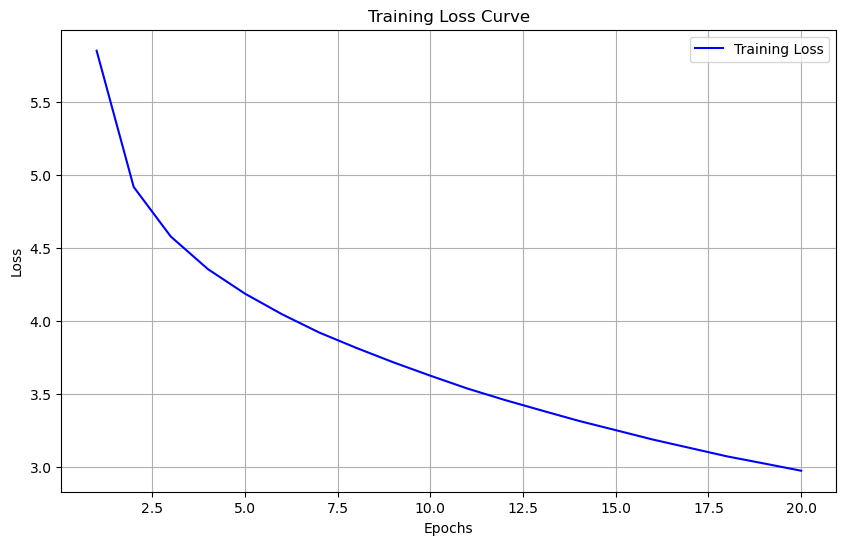

In [111]:
import matplotlib.pyplot as plt

# Loss values from your training output (replace with the actual loss values you have)
train_losses = [
    5.847795763905369, 4.914523594290463, 4.5751000347600055, 4.352262926599873,
    4.184005458959892, 4.042845732934439, 3.918032662388104, 3.8128471590867683,
    3.7139017724457073, 3.621993897566155, 3.534025015350598, 3.4561936408325806,
    3.383977654051425, 3.312921400176945, 3.2490196408353635, 3.184731990588245,
    3.1271846369531615, 3.0695784538717414, 3.020777788633731, 2.9712336649378734
]

# Plotting the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


## <font color="seagreen"> **Attention Visualization**

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(0.1)
    
    def attention(self, query, key, value, mask=None):
        # Scaled dot-product attention
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        output = torch.matmul(attn_weights, value)
        return output, attn_weights

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear transformations
        query = self.q_linear(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.k_linear(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.v_linear(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        attn_output, attn_weights = self.attention(query, key, value, mask)
        
        # Concatenate heads and pass through final linear layer
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        attn_output = self.out(attn_output)
        return attn_output, attn_weights


In [12]:
class EncoderLayer1(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer1, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x, attn_weights  # Return attention weights

class DecoderLayer1(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer1, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        self_attn_output, self_attn_weights = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))

        enc_dec_attn_output, enc_dec_attn_weights = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(enc_dec_attn_output))

        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x, self_attn_weights, enc_dec_attn_weights  # Return both self and enc-dec attention weights

class Encoder1(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout=0.1):
        super(Encoder1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer1(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoding(x)
        all_attn_weights = []
        for layer in self.layers:
            x, attn_weights = layer(x, mask)
            all_attn_weights.append(attn_weights)
        return x, all_attn_weights  # Return all attention weights

class Decoder1(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout=0.1):
        super(Decoder1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer1(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoding(x)
        all_self_attn_weights = []
        all_enc_dec_attn_weights = []
        for layer in self.layers:
            x, self_attn_weights, enc_dec_attn_weights = layer(x, enc_output, src_mask, tgt_mask)
            all_self_attn_weights.append(self_attn_weights)
            all_enc_dec_attn_weights.append(enc_dec_attn_weights)
        return x, all_self_attn_weights, all_enc_dec_attn_weights  # Return all attention weights
    
class Transformer1(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_pad_idx, tgt_pad_idx, d_model, num_heads, num_layers, d_ff, max_len, dropout=0.1):
        super(Transformer1, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.encoder = Encoder1(src_vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout)
        self.decoder = Decoder1(tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def make_src_mask(self, src):
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    def make_tgt_mask(self, tgt):
        tgt_pad_mask = (tgt != self.tgt_pad_idx).unsqueeze(1).unsqueeze(2)
        tgt_len = tgt.size(1)
        tgt_subseq_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        return tgt_pad_mask & tgt_subseq_mask

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        
        # Get encoder output and attention weights
        enc_output, enc_attn_weights = self.encoder(src, src_mask)
        
        # Get decoder output and attention weights
        dec_output, dec_self_attn_weights, dec_enc_dec_attn_weights = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        
        output = self.fc_out(dec_output)
        
        # Return both the transformer output and the attention weights
        return output, (enc_attn_weights, dec_self_attn_weights, dec_enc_dec_attn_weights)



In [13]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_pad_idx, tgt_pad_idx, d_model, num_heads, num_layers, d_ff, max_len, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.transformer = Transformer1(src_vocab_size, tgt_vocab_size, src_pad_idx, tgt_pad_idx, d_model, num_heads, num_layers, d_ff, max_len, dropout)

    def forward(self, src, tgt):
        # Forward pass through the transformer model
        transformer_output, attention_weights = self.transformer(src, tgt)
        # Return both the transformer output and attention weights
        return transformer_output, attention_weights


In [18]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece as spm
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# Load the trained tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.load("urdu_english_bpe_parallel.model")

# Define max sequence length and pad index
MAX_SEQ_LEN = 50
PAD_IDX = tokenizer.piece_to_id("<pad>")

d_model = 128
num_heads = 2
num_layers = 2
d_ff = 512
max_len = 200
dropout = 0.1

src_vocab_size = tokenizer.get_piece_size()
tgt_vocab_size = tokenizer.get_piece_size()


# Create the model
model1 = TransformerModel(src_vocab_size, tgt_vocab_size, PAD_IDX, PAD_IDX,
                         d_model, num_heads, num_layers, d_ff, max_len, dropout)

# Move the model to the appropriate device (e.g., GPU if available)
model1 = model1.to(device)

def plot_attention_weights(src_sentence, tgt_sentence, attention_weights, tokenizer):
    # Tokenize the sentences
    src_tokens = tokenizer.encode(src_sentence, out_type=str)
    tgt_tokens = tokenizer.encode(tgt_sentence, out_type=str)
    
    # Normalize attention weights for visualization
    attention_weights = attention_weights.squeeze().cpu().numpy()
    
    # Plot the attention weights
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, xticklabels=src_tokens, yticklabels=tgt_tokens,
                cmap='Blues', cbar=True, annot=False)
    plt.xlabel('Source (English) words')
    plt.ylabel('Target (Urdu) words')
    plt.title('Attention Visualization')
    plt.show()

def visualize_attention(model1, src_sentence, tgt_sentence, tokenizer, device):
    # Convert source and target sentence to tensors
    src_tensor = torch.tensor(tokenize_and_prepare([src_sentence]), dtype=torch.long).to(device)
    tgt_tensor = torch.tensor(tokenize_and_prepare([tgt_sentence]), dtype=torch.long).to(device)

    # Get the model output and attention weights
    with torch.no_grad():
        transformer_output, attention_weights = model1(src_tensor, tgt_tensor)

    # Unpack attention weights
    enc_attn_weights, dec_self_attn_weights, dec_enc_dec_attn_weights = attention_weights

    # Assuming you're visualizing the first layer's attention (adjust index as needed)
    # Decoding attention weights, change the indices to visualize different layers or heads
    layer_idx = 0  # Choose layer index (first layer)
    head_idx = 0   # Choose attention head index (first head)

    plot_attention_weights(src_sentence, tgt_sentence, dec_enc_dec_attn_weights[layer_idx][head_idx], tokenizer)

# Example usage
src_sentence = "This is an example sentence."
tgt_sentence = "یہ ایک مثال جملہ ہے۔"

# Assuming you have a trained transformer model loaded as `model1`
visualize_attention(model1, src_sentence, tgt_sentence, tokenizer, device)



ValueError: Must pass 2-d input. shape=(2, 50, 50)

<Figure size 1000x800 with 0 Axes>

## <font color="seagreen"> **Fine Tuning Pretrained Model**

In [ ]:
pip install transformers datasets torch

In [ ]:
pip install sacremoses

In [ ]:
pip install accelerate

In [ ]:
pip install torch==2.1.0

In [2]:
import torch
import accelerate

print("PyTorch version:", torch.__version__)
print("Accelerate version:", accelerate.__version__)


PyTorch version: 2.1.0+cpu
Accelerate version: 1.1.1


In [ ]:
pip uninstall torchvision

In [ ]:
pip install torchvision==0.15.0


In [7]:
from transformers import MarianMTModel, MarianTokenizer

# Load the pretrained MarianMT model for English-Urdu
model_name = "Helsinki-NLP/opus-mt-en-ur"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)


c:\Users\javer\Anaconda3\envs\pymc5_env\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
from transformers import Trainer, TrainingArguments

# Assume you have a validation dataset (for example, you can split your data)
validation_data = Dataset.from_dict({
    "en": en_sentences[:1000],  # Use a subset of sentences for validation
    "ur": ur_sentences[:1000]
})

# Tokenize the validation data
tokenized_validation_data = validation_data.map(tokenize_function, batched=True)

# Now, pass this dataset as the `eval_dataset`
trainer = Trainer(
    model=model,  # Pre-trained model to fine-tune
    args=training_args,  # Training arguments
    train_dataset=tokenized_dataset,  # Tokenized training dataset
    eval_dataset=tokenized_validation_data  # Validation dataset for evaluation
)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
from datasets import Dataset
from transformers import RobertaTokenizer  # Replace with your specific tokenizer

# Initialize your tokenizer (replace with SentencePiece tokenizer if needed)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')  # Or use the tokenizer of your model

# Sample data
en_sentences = ["Hello world.", "How are you?"]
ur_sentences = ["سلام دنیا", "آپ کیسے ہیں؟"]

# Create a dataset
data = {
    "en": en_sentences,
    "ur": ur_sentences
}

dataset = Dataset.from_dict(data)

# Tokenizer function with padding
def tokenize_function(examples):
    # Tokenize both the source (en) and target (ur) sentences
    inputs = tokenizer(examples['en'], padding=True, truncation=True, max_length=128, return_tensors="pt")
    targets = tokenizer(examples['ur'], padding=True, truncation=True, max_length=128, return_tensors="pt")
    
    # Return tokenized data in the expected format
    return {
        'input_ids': inputs['input_ids'].squeeze(),
        'attention_mask': inputs['attention_mask'].squeeze(),
        'labels': targets['input_ids'].squeeze()
    }

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Check the dataset
print(tokenized_dataset)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="no",  # Disable evaluation if you don't have a validation set
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=100
)

# Set up the Trainer with the properly formatted dataset
trainer = Trainer(
    model=model,  # Pre-trained model to fine-tune
    args=training_args,
    train_dataset=tokenized_dataset,  # Tokenized dataset
    eval_dataset=None  # No validation dataset for now
)

# Fine-tune the model
trainer.train()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\javer\Anaconda3\envs\pymc5_env\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\javer\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Dataset({
    features: ['en', 'ur', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2
})


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\javer\Anaconda3\envs\pymc5_env\Lib\site-packages\transformers\modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62024]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'train_runtime': 5.416, 'train_samples_per_second': 1.108, 'train_steps_per_second': 0.554, 'train_loss': 11.561149597167969, 'epoch': 3.0}


TrainOutput(global_step=3, training_loss=11.561149597167969, metrics={'train_runtime': 5.416, 'train_samples_per_second': 1.108, 'train_steps_per_second': 0.554, 'total_flos': 9533915136.0, 'train_loss': 11.561149597167969, 'epoch': 3.0})

In [16]:
model.save_pretrained('./model')  # Save the model
tokenizer.save_pretrained('./model')  # Save the tokenizer

('./model\\tokenizer_config.json',
 './model\\special_tokens_map.json',
 './model\\vocab.json',
 './model\\merges.txt',
 './model\\added_tokens.json')

In [35]:
from transformers import MarianMTModel, MarianTokenizer, Trainer, TrainingArguments
from datasets import Dataset

# Load the pretrained MarianMT model for English-Urdu
model_name = "Helsinki-NLP/opus-mt-en-ur"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Sample data (for the sake of example)
en_sentences = ["Hello world.", "How are you?"]
ur_sentences = ["سلام دنیا", "آپ کیسے ہیں؟"]

# Create a dataset
data = {
    "en": en_sentences,
    "ur": ur_sentences
}

# Create dataset from the data
dataset = Dataset.from_dict(data)

# Tokenization function
def tokenize_function(examples):
    # Tokenize both the source (en) and target (ur) sentences
    inputs = tokenizer(examples['en'], padding=True, truncation=True, max_length=128, return_tensors="pt")
    targets = tokenizer(examples['ur'], padding=True, truncation=True, max_length=128, return_tensors="pt")
    
    # Return tokenized data with labels (target is used as 'labels')
    return {
        'input_ids': inputs['input_ids'].squeeze(),
        'attention_mask': inputs['attention_mask'].squeeze(),
        'labels': targets['input_ids'].squeeze()  # Add target as labels
    }

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # For evaluation during training
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=100
)

# Initialize Trainer with the dataset and training arguments
trainer = Trainer(
    model=model,  # Pre-trained model to fine-tune
    args=training_args,  # Training arguments
    train_dataset=tokenized_dataset,  # Tokenized training dataset
    eval_dataset=tokenized_dataset  # Tokenized validation dataset (for this example, using the same)
)

# Fine-tune the model
trainer.train()

# Save the model and tokenizer
model.save_pretrained('./model')
tokenizer.save_pretrained('./model')

# Optionally, evaluate the model
eval_results = trainer.evaluate()
print(eval_results)


c:\Users\javer\Anaconda3\envs\pymc5_env\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 5.557419300079346, 'eval_runtime': 0.095, 'eval_samples_per_second': 21.052, 'eval_steps_per_second': 10.526, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 4.130854606628418, 'eval_runtime': 0.0983, 'eval_samples_per_second': 20.35, 'eval_steps_per_second': 10.175, 'epoch': 2.0}


c:\Users\javer\Anaconda3\envs\pymc5_env\Lib\site-packages\transformers\modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62024]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 3.5496418476104736, 'eval_runtime': 0.1126, 'eval_samples_per_second': 17.769, 'eval_steps_per_second': 8.885, 'epoch': 3.0}
{'train_runtime': 5.2598, 'train_samples_per_second': 1.141, 'train_steps_per_second': 0.57, 'train_loss': 6.180091222127278, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 3.5496418476104736, 'eval_runtime': 0.0995, 'eval_samples_per_second': 20.097, 'eval_steps_per_second': 10.049, 'epoch': 3.0}


In [20]:
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch

# Load pretrained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example dataset class
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, 
            add_special_tokens=True, 
            max_length=self.max_length, 
            padding='max_length', 
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Sample data
texts = ["I love machine learning", "I hate bugs"]
labels = [1, 0]  # 1 = positive, 0 = negative

# Prepare DataLoader
dataset = MyDataset(texts, labels, tokenizer, max_length=32)
train_loader = DataLoader(dataset, batch_size=2)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(3):
    for batch in train_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Evaluation
model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.7006701231002808
Epoch 2, Loss: 0.5639789700508118
Epoch 3, Loss: 0.41531068086624146


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## <font color="seagreen"> **Comparing Results to Custom Transformers**

In [55]:
import torch
# Load the trained tokenizer
custom_tokenizer = spm.SentencePieceProcessor()
custom_tokenizer.load("urdu_english_bpe_parallel.model")


# Define model hyperparameters
d_model = 128
num_heads = 2
num_layers = 2
d_ff = 512
max_len = 200
dropout = 0.1

src_vocab_size = custom_tokenizer.get_piece_size()
tgt_vocab_size = custom_tokenizer.get_piece_size()

    
# Initialize the Transformer model
# Assuming PAD_IDX is already defined, make sure both are passed:
custom_model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    src_pad_idx=PAD_IDX,  # src padding index
    tgt_pad_idx=PAD_IDX,  # tgt padding index
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_len=max_len,
    dropout=dropout
)


custom_model.load_state_dict(torch.load('transformer_translation1.pth'))
custom_model.to(device)
custom_model.eval()


Transformer(
  (encoder): Encoder(
    (embedding): Embedding(32000, 128)
    (pos_encoding): PositionalEncoding()
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (q_linear): Linear(in_features=128, out_features=128, bias=True)
          (k_linear): Linear(in_features=128, out_features=128, bias=True)
          (v_linear): Linear(in_features=128, out_features=128, bias=True)
          (out): Linear(in_features=128, out_features=128, bias=True)
        )
        (ff): FeedForward(
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (embedding)

In [64]:
import torch
import torch.nn.functional as F

device = 'cpu'

# Define a function to translate with the pretrained Marian model
def translate_with_marian_model(input_texts):
    # Tokenize input texts (each text individually)
    inputs = tokenizer.encode(input_texts, out_type=int)  # returns a list of token IDs
    inputs = torch.tensor(inputs).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension
    
    # Perform translation using Marian's generate method
    with torch.no_grad():
        translated = model.generate(inputs)  # Assuming model.generate() takes 'input_ids' only
    
    # Decode the translated text
    translated_texts = tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_texts


# Define a function to translate with the custom model (greedy decoding)
def translate_with_custom_model(input_texts):
    # Tokenize input texts (each text individually)
    input_ids = custom_tokenizer.encode(input_texts, out_type=int)  # returns a list of token IDs
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension
    
    # Start with the input IDs and generate the translation
    generated_ids = input_ids  # Start with input IDs
    with torch.no_grad():
        for _ in range(100):  # Limiting the number of tokens to generate
            outputs = custom_model(generated_ids)  # Assuming your custom model returns logits
            logits = outputs[0, -1, :]  # Get the logits for the last token
            
            # Get the token with the highest probability
            next_token_id = logits.argmax(dim=-1).unsqueeze(0).unsqueeze(0)  # Add batch and sequence dims
            generated_ids = torch.cat((generated_ids, next_token_id), dim=1)  # Append to the sequence
            
            # Check if end-of-sequence token is generated (adjust token ID accordingly)
            if next_token_id.item() == custom_tokenizer.piece_to_id('<eos>'):  # Assuming '<eos>' is end token
                break
    
    # Decode the translated text
    translated_texts = custom_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return translated_texts


# Example input sentences
input_sentences = ["Hello world.", "How are you?"]

# Get translations from both models
marian_translations = translate_with_marian_model(input_sentences)
custom_translations = translate_with_custom_model(input_sentences)

# Print the results for comparison
print("Marian Model Translations:", marian_translations)
print("Custom Transformer Model Translations:", custom_translations)


AttributeError: 'Transformer' object has no attribute 'generate'

In [65]:
from nltk.translate.bleu_score import corpus_bleu

# Example: List of reference translations (ground truth) and candidate translations
# Assume reference translations are a list of lists of tokens (since BLEU works on tokenized data)
references = [['سلام دنیا'], ['آپ کیسے ہیں؟']]  # Actual translations in Urdu
candidates_marian = [marian_translations.split()]
candidates_custom = [custom_translations.split()]

# Compute BLEU scores for both models
bleu_marian = corpus_bleu(references, candidates_marian)
bleu_custom = corpus_bleu(references, candidates_custom)

print(f"BLEU score for Marian Model: {bleu_marian}")
print(f"BLEU score for Custom Model: {bleu_custom}")


NameError: name 'custom_translations' is not defined

In [66]:
from torch.utils.data import DataLoader

# Define a DataLoader for your validation dataset
eval_dataloader = DataLoader(tokenized_eval_dataset, batch_size=32)

# Function to compute loss for custom model
def compute_loss_custom_model():
    total_loss = 0
    for batch in eval_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = custom_model(input_ids, labels=labels)
        total_loss += outputs.loss.item()  # Assuming the model returns loss
    return total_loss / len(eval_dataloader)

# Function to compute loss for Marian model
def compute_loss_marian_model():
    total_loss = 0
    for batch in eval_dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, labels=labels)
        total_loss += outputs.loss.item()  # Marian returns loss directly
    return total_loss / len(eval_dataloader)

# Calculate the losses
loss_custom = compute_loss_custom_model()
loss_marian = compute_loss_marian_model()

print(f"Loss for Custom Model: {loss_custom}")
print(f"Loss for Marian Model: {loss_marian}")


AttributeError: 'list' object has no attribute 'to'